In [28]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

def readFile(filename):

    data = {"ch0": [], "ch1": [], "ch3": []}

    with open(filename) as file:

        # skip file header
        file.readline()
        file.readline()
        file.readline()
        file.readline()

        while True:

            # skip event header and check end of file
            if not file.readline(): break
            file.readline()

            # skip channel 0 header
            file.readline()

            ch0_vals = file.readline()
            ch0_vals = list(map(lambda x: -float(x), ch0_vals.split()))
            data["ch0"].append(np.array(ch0_vals))

            # skip channel 1 header
            file.readline()

            ch1_vals = file.readline()
            ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
            data["ch1"].append(np.array(ch1_vals))

            # skip channel 2 header
            file.readline()

            ch3_vals = file.readline()
            ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
            data["ch3"].append(np.array(ch3_vals))

    data["ch0"] = np.array(data["ch0"])
    data["ch1"] = np.array(data["ch1"])
    data["ch3"] = np.array(data["ch3"])

    return data

##  ################  ################  ################
##  Slow wave catcher
##  ################  ################  ################
data_slow = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_100 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_SLOW = 100
times_slow = np.arange(1024)*SAMPLE_RATE_SLOW

data_slow["times"] = times_slow
data_slow["sample_rate"] = SAMPLE_RATE_SLOW
data_slow["type"] = "slow"


##  ################  ################  ################
##  Fast wave catcher
##  ################  ################  ################
data_fast = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_2.5 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_FAST = 2.5
times_fast = np.arange(1024)*SAMPLE_RATE_FAST

data_fast["times"] = times_fast
data_fast["sample_rate"] = SAMPLE_RATE_FAST
data_fast["type"] = "fast"

In [29]:
def align_datasamples(data):

    # start index
    data["st_idx"] = np.empty(data["ch0"].shape[0], dtype=int)

    for i in range(data["ch0"].shape[0]):

        max_val = np.max(data["ch0"][i])

        start_idx = np.argmax(data["ch0"][i] >= 0.5*max_val)

        if data["type"] == "fast":
            # remove bad events. ch0 max value is about 0.8 for all good events.
            if np.max(data["ch0"][i]) < 0.6:
                start_idx = 0

        elif data["type"] == "slow":
            # sometimes we have two synchro peacks, the correct one is first and low in y scale
            # this if branch of code to account for that effect
            if start_idx > 100:
                
                start_idx = np.argmax(data["ch0"][i] >= 0.03)

        else:
            print("ERROR: unknown wave catcher type")

        data["st_idx"][i] = start_idx

    min_st_idx = int(np.min(data["st_idx"]))
    max_st_idx = int(np.max(data["st_idx"]))

    data["min_st_idx"] = min_st_idx
    data["max_st_idx"] = max_st_idx

    data_shifted = dict(data)
    data_shifted["ch0"] = np.empty([ data["ch0"].shape[0], data["ch0"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch1"] = np.empty([ data["ch1"].shape[0], data["ch1"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch3"] = np.empty([ data["ch3"].shape[0], data["ch3"].shape[1] - (max_st_idx-min_st_idx) ])


    for i in range(data["ch0"].shape[0]):

        stIdx = data["st_idx"][i]

        start_idx = stIdx-min_st_idx
        stop_ind  = data["ch0"][i].size -(max_st_idx-stIdx)

        data_shifted["ch0"][i] = data["ch0"][i, start_idx: stop_ind]
        data_shifted["ch1"][i] = data["ch1"][i, start_idx: stop_ind]
        data_shifted["ch3"][i] = data["ch3"][i, start_idx: stop_ind]

    data_shifted["times"] = data["times"][:-(max_st_idx-min_st_idx)]

    return data_shifted

data_fast_aligned = align_datasamples(data_fast)
data_slow_aligned = align_datasamples(data_slow)

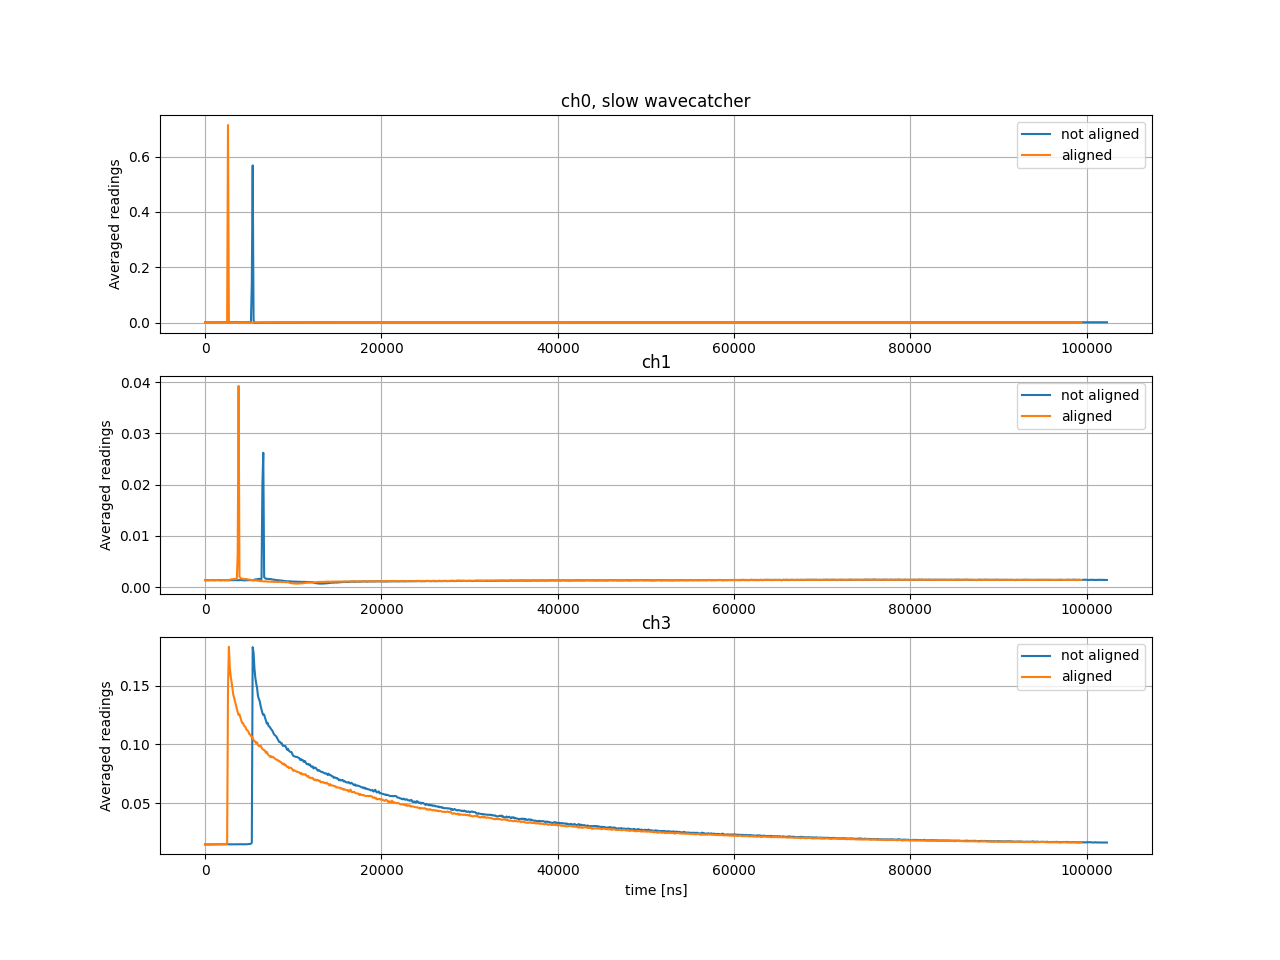

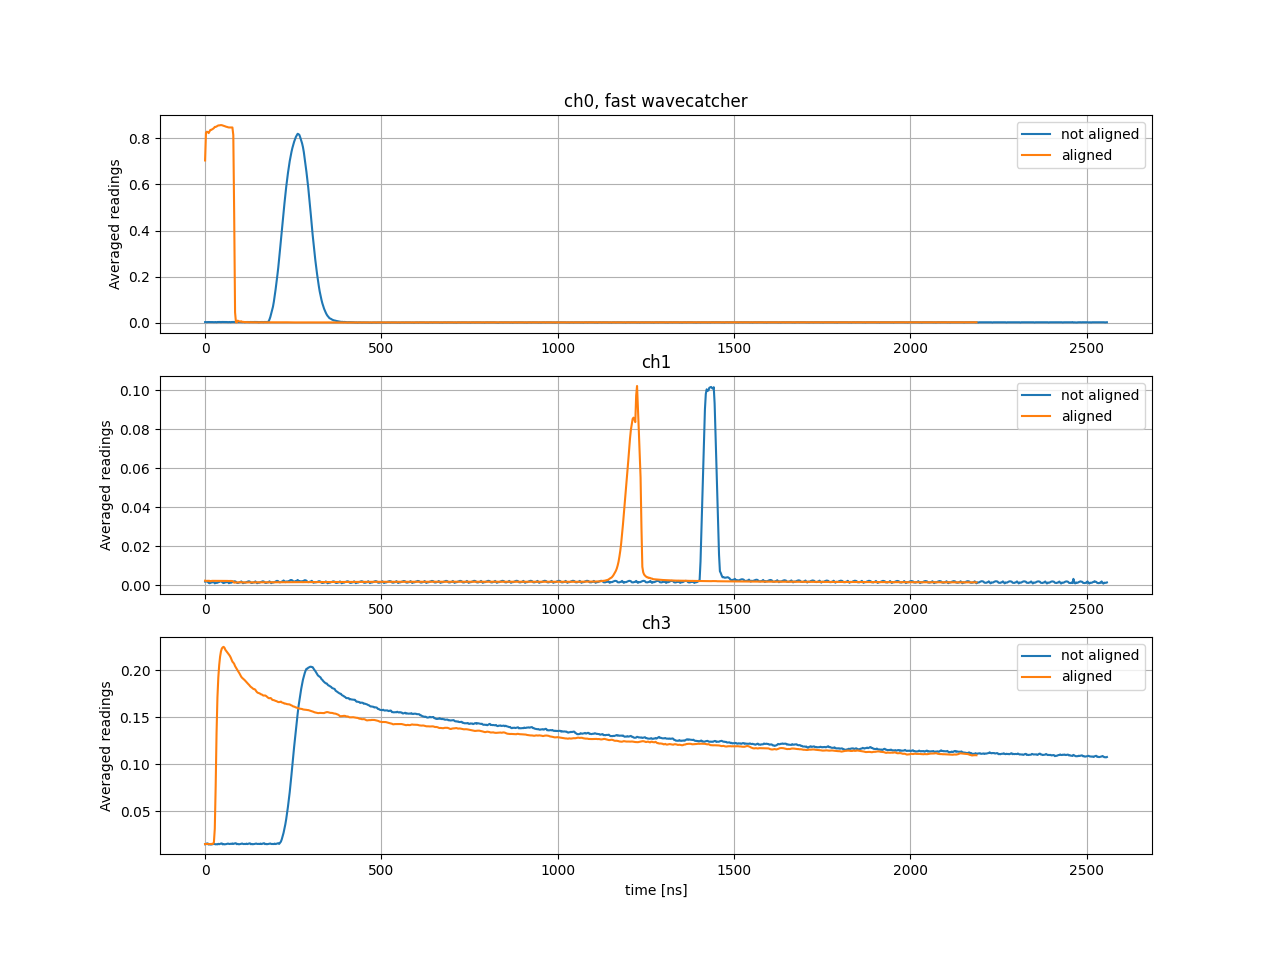

In [30]:
def visualise_aligning(data_raw, data_aligned):

    plt.figure(figsize=(6.4*2, 4.8*2))

    assert data_raw["type"] == data_aligned["type"]


    plt.subplot(3,1,1)
    plt.plot(data_raw["times"], np.mean(data_raw["ch0"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch0"], axis=0), label="aligned")
    plt.title(f"ch0, {data_raw['type']} wavecatcher")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,2)
    plt.plot(data_raw["times"], np.mean(data_raw["ch1"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch1"], axis=0), label="aligned")
    plt.title("ch1")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.subplot(3,1,3)
    plt.plot(data_raw["times"], np.mean(data_raw["ch3"], axis=0), label="not aligned")
    plt.plot(data_aligned["times"], np.mean(data_aligned["ch3"], axis=0), label="aligned")
    plt.title("ch3")
    plt.legend()
    plt.grid()
    plt.ylabel("Averaged readings")

    plt.xlabel("time [ns]")


visualise_aligning(data_slow, data_slow_aligned)
visualise_aligning(data_fast, data_fast_aligned)

/tmp/ipykernel_5938/3334714555.py:37: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6.4*2, 4.8))


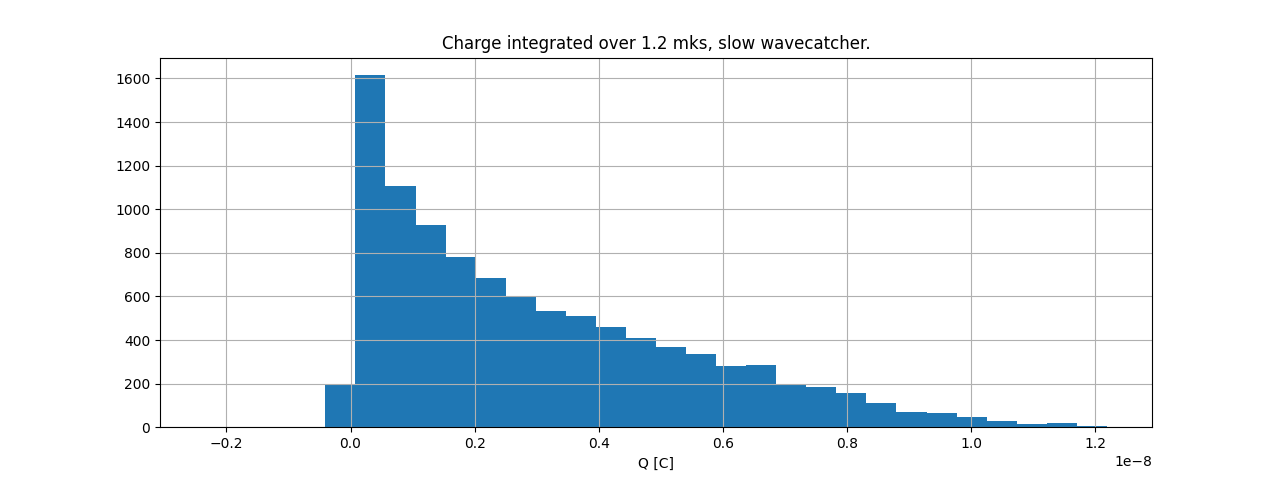

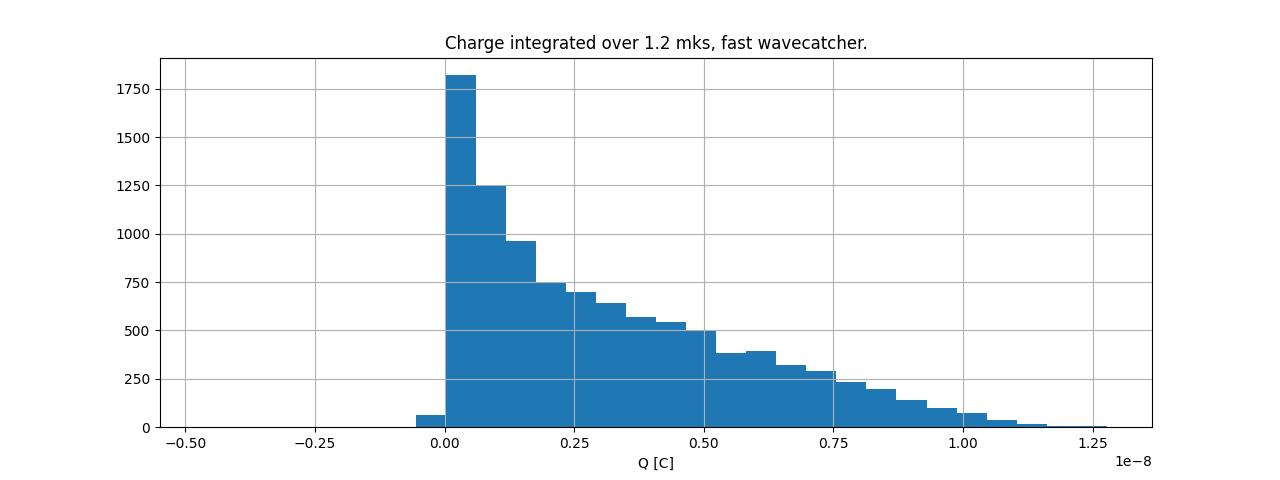

In [31]:
def calc_charge(data):

    if data["type"] == "fast":
        resistance = 50 # ohm
        st_idx = int(np.floor(22/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(90/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))
    elif data["type"] == "slow":
        resistance = 50 # ohm
        st_idx = int(np.floor(2500/data["sample_rate"]))
        md_idx = st_idx + int(np.floor(300/data["sample_rate"]))
        ed_idx = st_idx + int(np.floor(1200/data["sample_rate"]))        
    else:
        print("ERROR: unknown type of the wave catcher")


    data["Qc_arr"] = np.empty(data["ch3"].shape[0])
    data["Qs_arr"] = np.empty(data["ch3"].shape[0])

    data["baseline"] = np.empty(data["ch3"].shape[0])


    for i in range(data["ch3"].shape[0]):

        bkg = np.mean(data["ch3"][i, :st_idx])
        data["baseline"][i] = bkg

        Qc = (data["ch3"][i, st_idx:md_idx] - bkg)/resistance 
        Qc = np.sum(Qc)*data["sample_rate"]*1e-9
        data["Qc_arr"][i] = Qc

        Qs = (data["ch3"][i, md_idx:ed_idx] - bkg)/resistance
        Qs = np.sum(Qs)*data["sample_rate"]*1e-9
        data["Qs_arr"][i] = Qs
        

    plt.figure(figsize=(6.4*2, 4.8))
    plt.hist(data["Qc_arr"]+data["Qs_arr"], bins=30)
    plt.title(f"Charge integrated over 1.2 mks, {data['type']} wavecatcher.")
    plt.xlabel("Q [C]")
    plt.grid()


calc_charge(data_slow_aligned)
calc_charge(data_fast_aligned)

In [32]:
from enum import Enum, auto

class EvtType(Enum):
    Cherencov = auto()
    ZeroQc = auto()
    BadBaseline = auto()
    Good = auto()


def decide_event_acceptance(data):

    evtTypes = np.ones_like(data["Qs_arr"])*EvtType.Good.value

    if data["type"] == "fast":

        discrimination_curve = lambda x: 2.5*(x-0.05)   
        data["discrimination_curve"] = discrimination_curve      

        badBaseThresh = 0.0165

    elif data["type"] == "slow":

        discrimination_curve = lambda x: 0.50*(x-0.05)     
        data["discrimination_curve"] = discrimination_curve     

        badBaseThresh = 0.0165

    else:

        print("ERROR: unknown type of the wave catcher")


    # Removing cherencov events
    rejectedCherenkov = (data["Qs_arr"]/1e-9 < discrimination_curve(data["Qc_arr"]/1e-9))
    evtTypes[rejectedCherenkov] = EvtType.Cherencov.value
    
    # Removing bad baseline
    rejectBaseline = data["baseline"] > badBaseThresh
    evtTypes[rejectBaseline] = EvtType.BadBaseline.value

    data["evtTypes"] = evtTypes

    data["ch3_average"] = np.mean(data["ch3"][evtTypes == EvtType.Good.value], axis=0)


decide_event_acceptance(data_slow_aligned)
decide_event_acceptance(data_fast_aligned)   

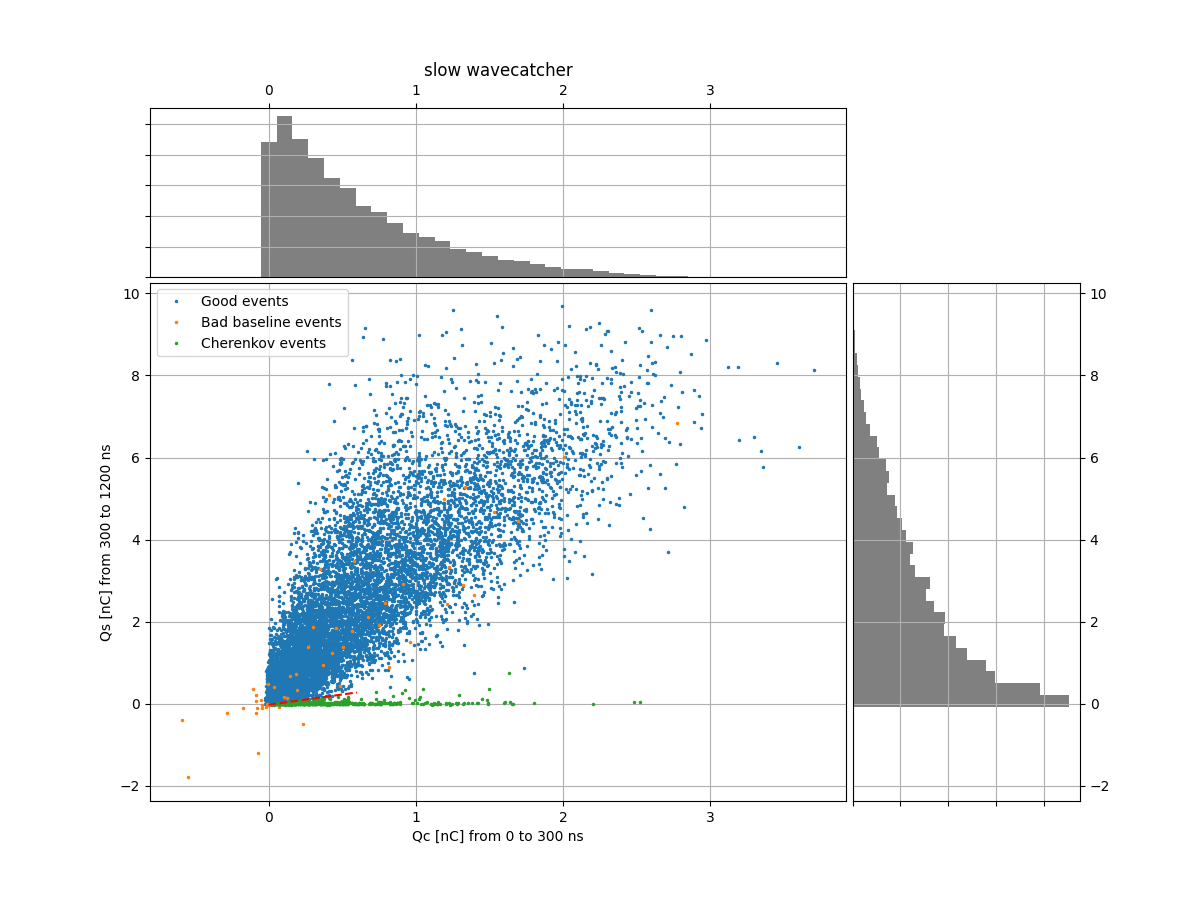

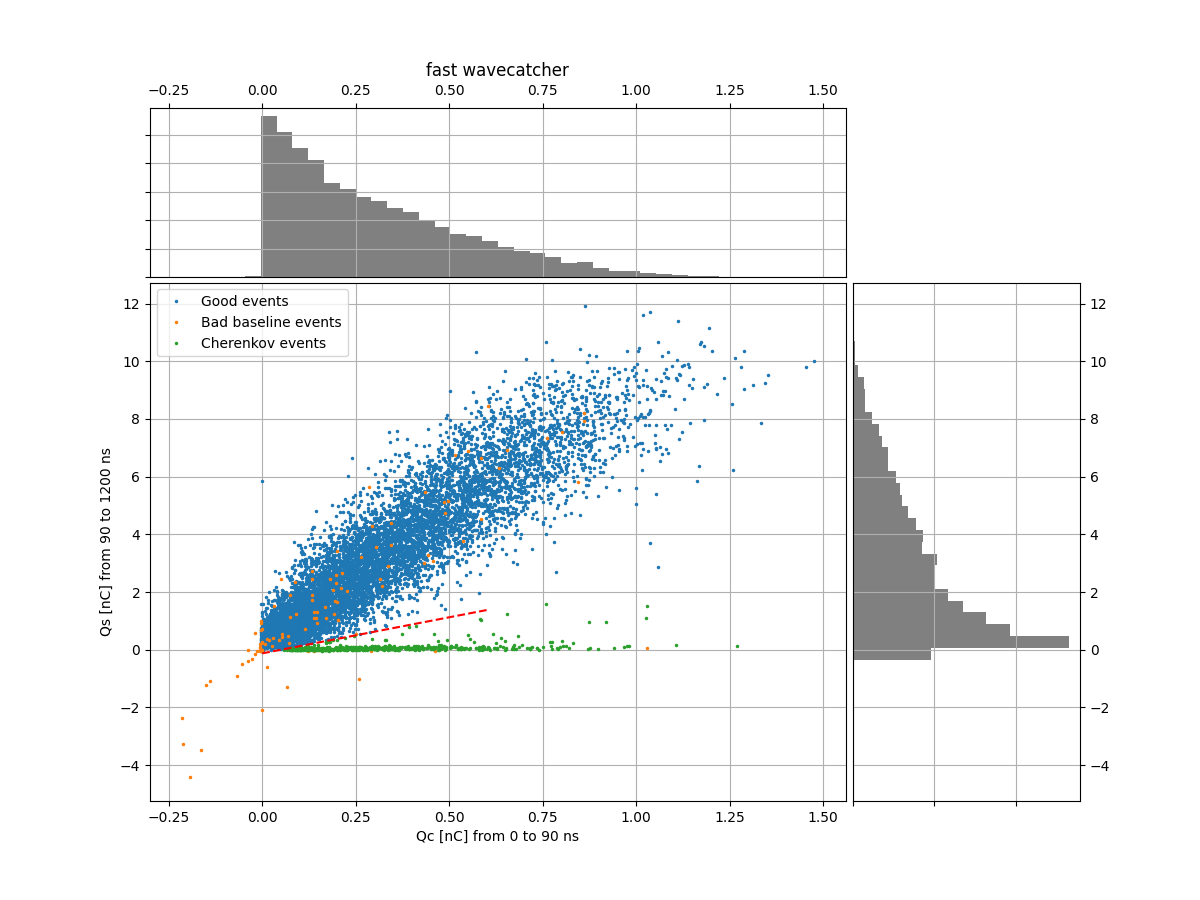

In [44]:
def visualise_charges(data):

    # Set up the axes with gridspec
    fig = plt.figure(figsize=(12, 9))
    grid = plt.GridSpec(4, 4, hspace=0.03, wspace=0.03)
    main_ax = fig.add_subplot(grid[1:, :-1])
    y_hist = fig.add_subplot(grid[1:, -1], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[0, :-1], yticklabels=[], sharex=main_ax)
    
    # scatter points on the main axes
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.Good.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.Good.value]/1e-9, ".", markersize=3, label="Good events")
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.BadBaseline.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.BadBaseline.value]/1e-9, ".", markersize=3, label="Bad baseline events")
    main_ax.plot(data["Qc_arr"][data["evtTypes"] == EvtType.Cherencov.value]/1e-9, data["Qs_arr"][data["evtTypes"] == EvtType.Cherencov.value]/1e-9, ".", markersize=3, label="Cherenkov events")

    if data["type"] == "fast":
        main_ax.set_xlabel("Qc [nC] from 0 to 90 ns")
        main_ax.set_ylabel("Qs [nC] from 90 to 1200 ns")   
    elif data["type"] == "slow":
        main_ax.set_xlabel("Qc [nC] from 0 to 300 ns")
        main_ax.set_ylabel("Qs [nC] from 300 to 1200 ns")           
    else:
        print("ERROR: unknown type of the wave catcher")

    main_ax.grid()
    main_ax.legend()


    # histogram on the attached axes
    x_hist.hist(data["Qc_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='vertical', color='gray')
    x_hist.xaxis.set_label_position('top')
    x_hist.xaxis.tick_top()
    x_hist.grid()
    x_hist.set_title(f"{data['type']} wavecatcher")


    y_hist.hist(data["Qs_arr"]/1e-9, 40, histtype='stepfilled',
            orientation='horizontal', color='gray')
    y_hist.yaxis.set_label_position('right')
    y_hist.yaxis.tick_right()
    y_hist.grid()

    
    disc_x_c = np.array([0, 0.6])
    disc_y_c = data['discrimination_curve'](disc_x_c)
    main_ax.plot(disc_x_c, disc_y_c, "--r")    

visualise_charges(data_slow_aligned)
visualise_charges(data_fast_aligned)

## Dark current removal

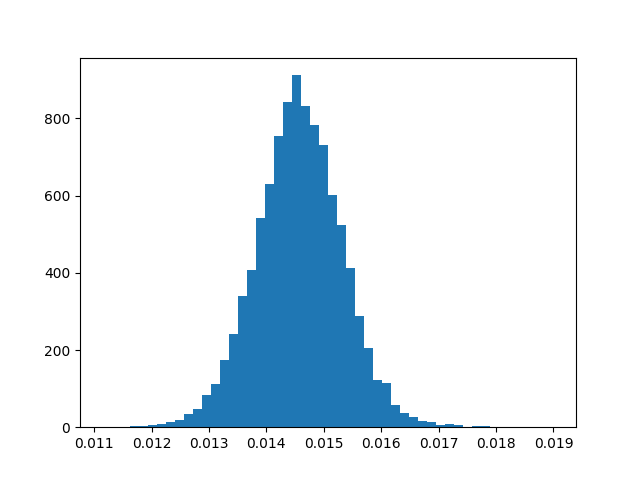

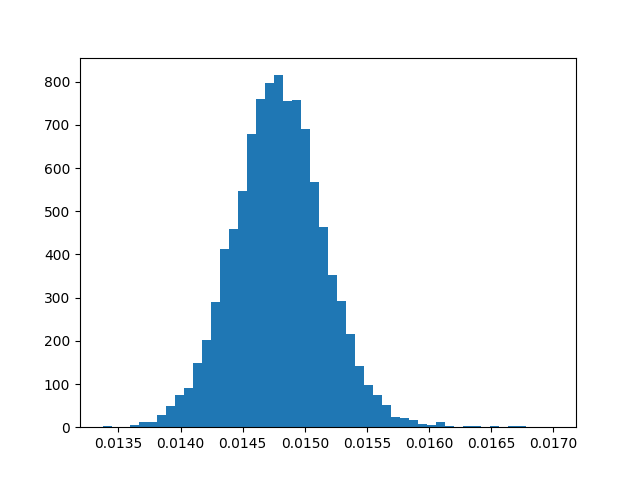

In [45]:
plt.figure()
plt.hist(data_fast_aligned["baseline"], bins=50, range=(np.min(data_fast_aligned["baseline"]), 0.019))

plt.figure()
plt.hist(data_slow_aligned["baseline"], bins=50, range=(np.min(data_slow_aligned["baseline"]), 0.017));

## Analysis of event which has zero $Q_c$ but not zero $Q_s$

In [46]:
# events_num = np.nonzero((data_slow_aligned["Qs_arr"]/1e-9 <= data_slow_aligned['discrimination_curve'](data_slow_aligned["Qc_arr"]/1e-9)) *\
#                         (data_slow_aligned["baseline"] < 0.0165))[0]

# for EVENT_NUMBER in list(events_num):

#     print("EVENT_NUMBER =", EVENT_NUMBER)

#     # fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4, 4.8), constrained_layout=True)
#     fig, ax1 = plt.subplots(1,1, figsize=(6.4, 4.8/2), constrained_layout=True)

#     line11 = ax1.plot(data_slow_aligned["times"], data_slow_aligned["ch3"][EVENT_NUMBER], color="blue", label="measurement")
#     ax1.set_ylabel("Channel 3")
#     ax1.grid()
#     ax1.set_title(f"Event number {EVENT_NUMBER}, fast wave catcher")
#     ax1.set_xlabel("Time [ns]")

#     ax1s = ax1.twinx()
#     line12 = ax1s.plot(data_slow_aligned["times"], data_slow_aligned["ch0"][EVENT_NUMBER], "--r", label="synchronisation")
#     ax1s.set_ylabel("Channel 0")

#     lines = [line11[0], line12[0]]
#     labels = [line.get_label() for line in lines]
#     ax1.legend(lines, labels, loc='upper right')


#     # ax2.plot(data_slow["times"], data_slow["ch3"][EVENT_NUMBER], color="blue")
#     # ax2.set_ylabel("Channel 3")
#     # ax2.grid()
#     # ax2.set_title(f"Event number {EVENT_NUMBER}, slow wave catcher")
#     # ax2.set_xlabel("Time [ns]")

#     # ax2s = ax2.twinx()
#     # ax2s.plot(data_slow["times"], data_slow["ch0"][EVENT_NUMBER], "--r")
#     # ax2s.set_ylabel("Channel 0")

#     plt.savefig(f"plots/{EVENT_NUMBER}.png")

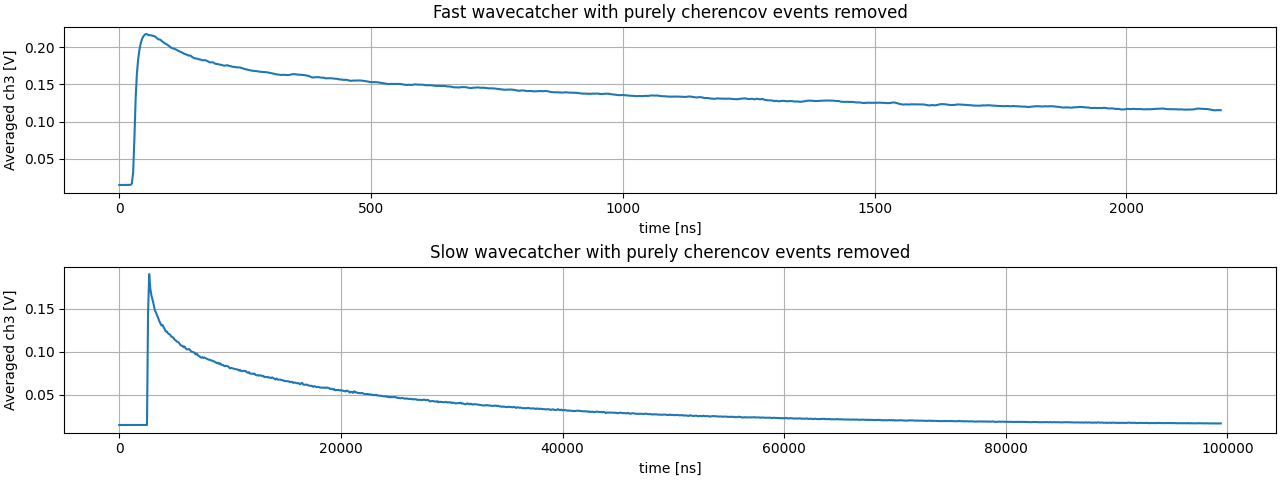

In [47]:
plt.figure(figsize=(6.4*2, 4.8), constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(data_fast_aligned["times"], data_fast_aligned["ch3_average"])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Fast wavecatcher with purely cherencov events removed")
plt.grid()


plt.subplot(2,1,2)
plt.plot(data_slow_aligned["times"], data_slow_aligned["ch3_average"])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Slow wavecatcher with purely cherencov events removed")
plt.grid()

## Aligning zero time of averaged curve

In [48]:
def get_t0_aligned_t_and_V(data):

    max_V = np.max(data["ch3_average"])

    t0_idx = np.argmax(data["ch3_average"] > 0.5*max_V)
    
    zero_baseline = np.mean( data["ch3_average"][:int(t0_idx/2)])

    return data["times"]-t0_idx*data["sample_rate"], data["ch3_average"]-zero_baseline

data_fast_aligned["times_t0"], data_fast_aligned["ch3_average_t0"] = get_t0_aligned_t_and_V(data_fast_aligned)
data_slow_aligned["times_t0"], data_slow_aligned["ch3_average_t0"] = get_t0_aligned_t_and_V(data_slow_aligned)

Text(0.63, 0.33, 'A = 0.1957 V\n$\\tau$ = 1029.9313 ns')

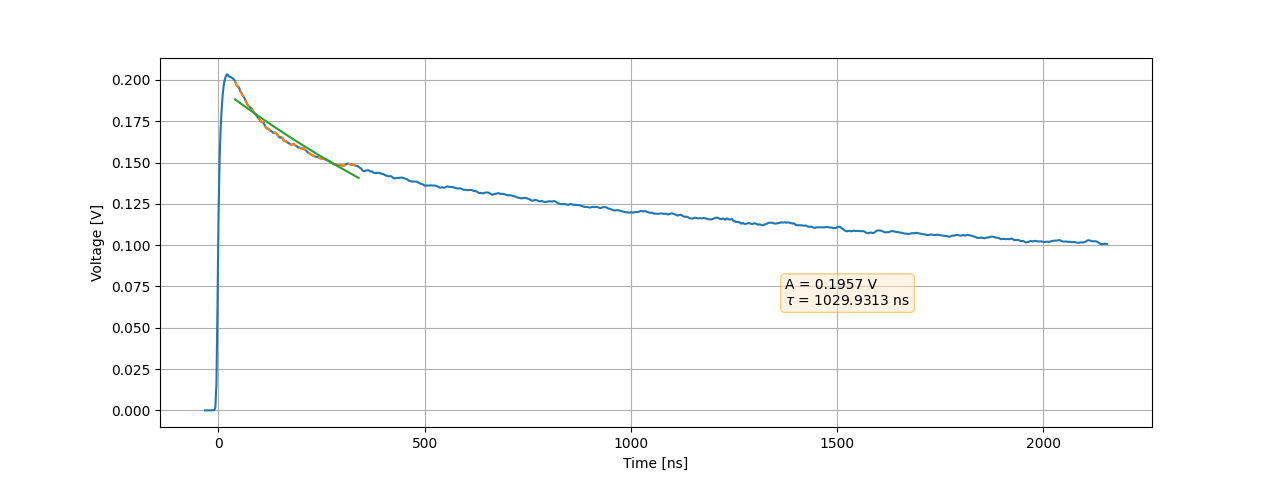

In [49]:
from scipy.optimize import curve_fit

F_ST_FIT_TIM = 40  # ns

F_ST_FIT_IDX = np.argmax(data_fast_aligned["times_t0"] >= F_ST_FIT_TIM)

MAX_IDX = 150

f_tim_fit = data_fast_aligned["times_t0"][F_ST_FIT_IDX:MAX_IDX]
f_dat_fit = data_fast_aligned["ch3_average_t0"][F_ST_FIT_IDX:MAX_IDX]

pars0 = [0.3, 90]

exp = lambda t, A, tau: A*np.exp(-t/tau)

pars, pcov = curve_fit(exp, f_tim_fit, f_dat_fit, p0 = pars0)

A, tau = pars

plt.figure(figsize=(6.4*2, 4.8))
plt.plot(data_fast_aligned["times_t0"], data_fast_aligned["ch3_average_t0"])
plt.plot(f_tim_fit, f_dat_fit, "--")
plt.plot(f_tim_fit, exp(f_tim_fit, *pars))

plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")

plt.grid()

bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
plt.gca().text( 0.63, 0.33,
               "A = {:.4f} V\n".format(A)+\
               "$\\tau$ = {:.4f} ns".format(tau),    
               transform = plt.gca().transAxes, bbox=bbox)

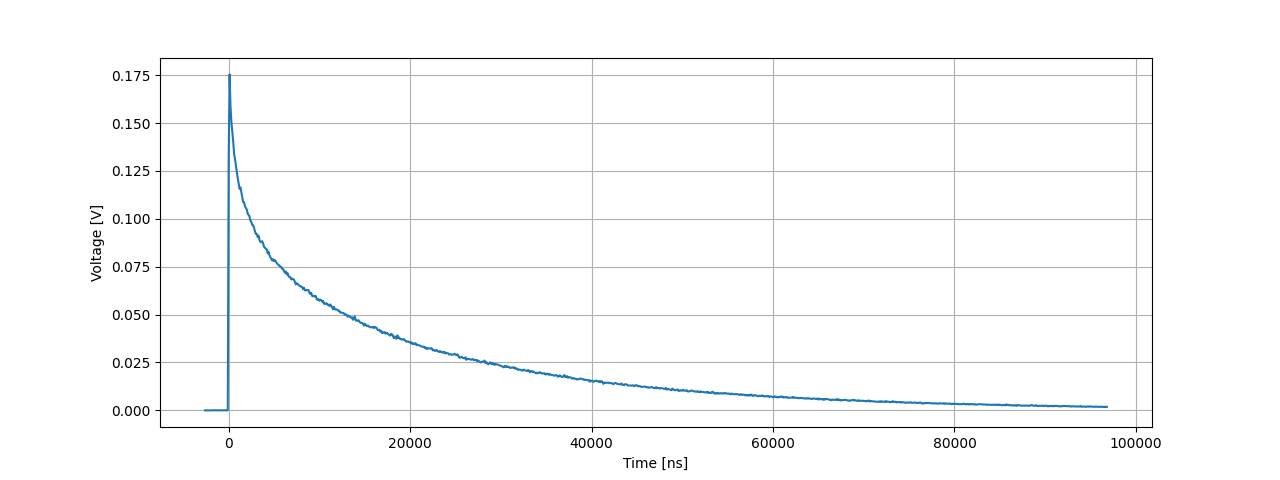

In [50]:
plt.figure(figsize=(6.4*2, 4.8))
plt.plot(data_slow_aligned["times_t0"], data_slow_aligned["ch3_average_t0"])
# plt.plot(f_tim_fit, f_dat_fit, "--")
# plt.plot(f_tim_fit, exp(f_tim_fit, *pars))

plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")

plt.grid()

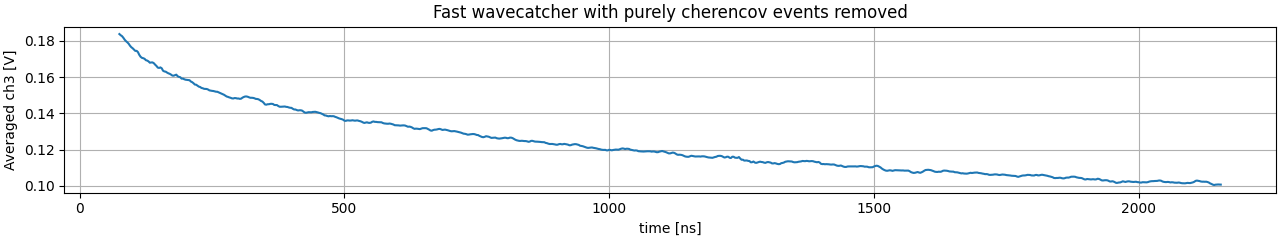

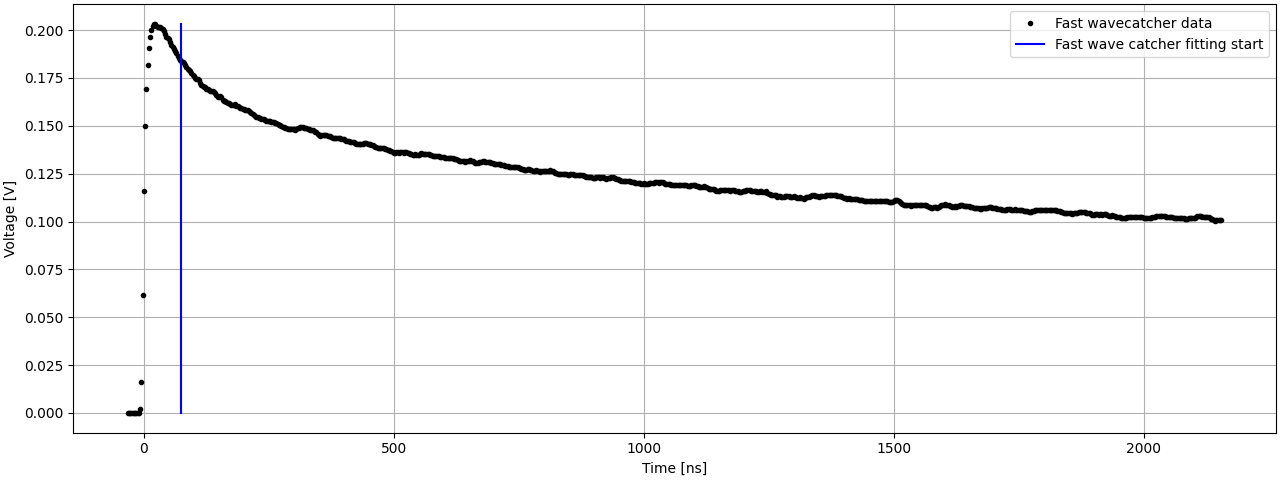

In [51]:
F_ST_FIT_TIM = 75   # ns

F_ST_FIT_IDX = np.argmax(data_fast_aligned["times_t0"] >= F_ST_FIT_TIM)

plt.figure(figsize=(6.4*2, 4.8/2), constrained_layout=True)
plt.plot(data_fast_aligned["times_t0"][F_ST_FIT_IDX:], data_fast_aligned["ch3_average_t0"][F_ST_FIT_IDX:])
plt.ylabel("Averaged ch3 [V]")
plt.xlabel("time [ns]")
plt.title("Fast wavecatcher with purely cherencov events removed")
plt.grid()



plt.figure(figsize=(6.4*2, 4.8), constrained_layout=True)
plt.plot(data_fast_aligned["times_t0"], data_fast_aligned["ch3_average_t0"], ".k", label="Fast wavecatcher data")

max_V = np.max(data_fast_aligned["ch3_average_t0"])

plt.plot([F_ST_FIT_TIM-0.1*SAMPLE_RATE_FAST, F_ST_FIT_TIM-0.1*SAMPLE_RATE_FAST], [0, max_V], "-b", label = "Fast wave catcher fitting start")

plt.xlabel("Time [ns]")
plt.ylabel("Voltage [V]")
plt.legend()
plt.grid()

In [52]:
# from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import curve_fit

f_tim_fit = data_fast_aligned["times_t0"][F_ST_FIT_IDX:]
f_dat_fit = data_fast_aligned["ch3_average_t0"][F_ST_FIT_IDX:]

def fitFunc(t, A1, A2, A3, A4, L1, L2, L3, L4):

    return A1*np.exp(-L1*(t)) + A2*np.exp(-L2*(t)) + A3*np.exp(-L3*(t)) + A4*np.exp(-L4*(t))

def objective(argument):

    A1, A2, A3, A4, L1, L2, L3, L4 = argument

    tf = f_tim_fit

    f_pred = A1*np.exp(-L1*(tf)) + A2*np.exp(-L2*(tf)) + A3*np.exp(-L3*(tf)) + A4*np.exp(-L4*(tf))

    f_loss = np.sqrt(np.sum((f_pred-f_dat_fit)**2)/f_dat_fit.size)

    return f_loss

def get_fit_params():

    # Another good results with slow redings starting gtom 2 mus
    A1 = 0.07228202832433435
    A2 = 0.04680483155184595
    A3 = 0.04662590654689548
    A4 = 0.051448656362562066
    L1 = 3.841905007522243e-05
    L2 = 0.00013373087715952030
    L3 = 0.0013681473020424693
    L4 = 0.011026657348544421


    pars = [A1, A2, A3, A4, L1, L2, L3, L4]

    bounds = [
        ( A1*  0.5,  A1*  1.5),  # A1
        ( A2*  0.5,  A2*  1.5),  # A2
        ( A3*  0.5,  A3*  1.5),  # A3
        ( A4*  0.5,  A4*  1.5),  # A4
        ( L1* 0.99,  L1* 1.01),  # L1
        ( L2* 0.99,  L2* 1.01),  # L2
        ( L3*  0.5,  L3*  1.5),  # L3
        ( L4*  0.5,  L4*  1.5),  # L4
    ]


    bounds_low = [b[0] for b in bounds]
    bounds_hig = [b[1] for b in bounds]
    bounds = [bounds_low, bounds_hig]
    pars, _ = curve_fit(fitFunc, f_tim_fit, f_dat_fit, pars, bounds=bounds, max_nfev=1000)
    A1, A2, A3, A4, L1, L2, L3, L4 = pars


    # minim_results = minimize(objective, x0=pars, bounds=bounds)

    # minim_results = dual_annealing(objective, 
    #                                bounds, 
    #                                x0 = pars,
    #                                maxiter=20000,            # More iterations → better chance to find global min
    #                                initial_temp=9230.0,      # Higher starting temperature → broader search
    #                                restart_temp_ratio=2e-5,  # Lower value → longer before restarting
    #                                visit=10.62,              # Controls exploration of space
    #                                accept=-50.0,             # Controls acceptance of worse solutions
    #                                no_local_search=False,    # Enables local search after annealing phase
    #                                ) 

    # minim_results = dual_annealing(objective, bounds, x0 = pars) 

    # A1, A2, A3, A4, L1, L2, L3, L4 = minim_results.x

    result = {
        "A1" : A1,
        "A2" : A2,
        "A3" : A3,
        "A4" : A4,
        "L1" : L1,
        "L2" : L2,
        "L3" : L3,
        "L4" : L4
        }
    
    return result

# Fitting of merged fase and slow readings

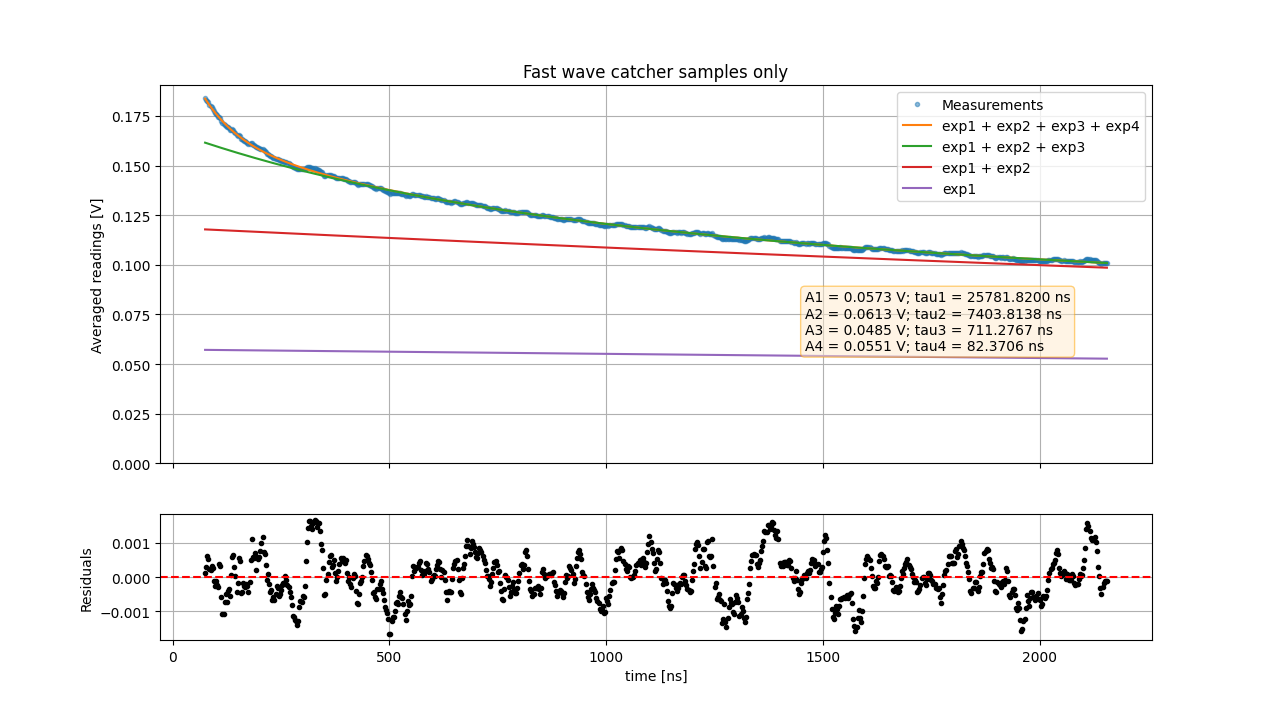

In [53]:
fig,(axm, axe) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=(6.4*2,4.8*1.5))


#############################################
## Perform fitting and draw it on the plot ##
#############################################

times_plot = np.linspace(np.min(f_tim_fit), np.max(f_tim_fit), int((np.max(f_tim_fit) - np.min(f_tim_fit))/data_fast["sample_rate"]))

fit_params = get_fit_params()

A1, A2, A3, A4, L1, L2, L3, L4 = fit_params.values()

axm.plot(f_tim_fit, f_dat_fit, ".", label = "Measurements", alpha = 0.5)

axm.plot(times_plot, fitFunc(times_plot, A1, A2, A3, A4, L1, L2, L3, L4), label = "exp1 + exp2 + exp3 + exp4")

exp123 = lambda t: A1*np.exp(-L1*t) + A2*np.exp(-L2*t) + A3*np.exp(-L3*t)
axm.plot(times_plot, exp123(times_plot), label="exp1 + exp2 + exp3")

exp12 = lambda t: A1*np.exp(-L1*t) + A2*np.exp(-L2*t)
axm.plot(times_plot, exp12(times_plot), label="exp1 + exp2")

exp1 = lambda t: A1*np.exp(-L1*t)
axm.plot(times_plot, exp1(times_plot), label="exp1")

axm.set_ylabel("Averaged readings [V]")
axm.set_ylim(0, None)
axm.grid()
axm.legend()
axm.set_title("Fast wave catcher samples only")


bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
axm.text( 0.65, 0.3,
         "A1 = {:.4f} V; tau1 = {:.4f} ns\n".format(fit_params["A1"], 1/fit_params["L1"])+\
         "A2 = {:.4f} V; tau2 = {:.4f} ns\n".format(fit_params["A2"], 1/fit_params["L2"])+\
         "A3 = {:.4f} V; tau3 = {:.4f} ns\n".format(fit_params["A3"], 1/fit_params["L3"])+\
         "A4 = {:.4f} V; tau4 = {:.4f} ns  ".format(fit_params["A4"], 1/fit_params["L4"]),      
         transform = axm.transAxes, bbox=bbox)


#########################################################
## Perform estimation and draw of the uncertainty bars ##
#########################################################

# # Compute uncertainty in fit
# num_samples = 10000  # Number of Monte Carlo samples for uncertainty estimation
# param_samples = np.random.multivariate_normal(list(fit_params.values()), pconv, size=num_samples)

# y_fits = np.array([fitFunc(times_merged, *p) for p in param_samples])
# y_fit_mean = np.mean(y_fits, axis=0)
# y_fit_std = np.std(y_fits, axis=0)

residuals = f_dat_fit - fitFunc(f_tim_fit, A1, A2, A3, A4, L1, L2, L3, L4)

# Plot the residuals with error bars
axe.plot(f_tim_fit, residuals, ".k")
axe.axhline(0, color="red", linestyle="--")
# axe.fill_between(times_merged, -2 * y_fit_std, 2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

# axm.fill_between(times_merged, y_fit_mean-2 * y_fit_std, y_fit_mean+2 * y_fit_std, 
#                    color="red", alpha=0.3, label="95% CI")

axe.set_ylabel("Residuals")
axe.set_xlabel("time [ns]")
# axe.legend()
axe.grid()


In [54]:
for key, value in fit_params.items():

    print(key,"=", value)

A1 = 0.0573326663610496
A2 = 0.06127743960126158
A3 = 0.048526779361111855
A4 = 0.055101236428307145
L1 = 3.878702124974719e-05
L2 = 0.00013506552530576402
L3 = 0.0014059225716802118
L4 = 0.012140257802836108
